In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import theano
print("Theano version:",theano.__version__)
import sys
print (sys.version)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Couldn't import dot_parser, loading of dot files will not be possible.
Theano version: 0.9.0
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


## Grab the input data

In [3]:
!./grab_data.sh

File task0importancescores.npy exists already
File task0hypimpscores.npy exists already
File sequences.txt exists already


### Functions for one-hot encoding sequences

In [3]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    #theano dim ordering, uses row axis for one-hot
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip("\n") for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split("\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta)

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [4]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    task_to_scores[task] = np.array(f['contrib_scores'][task])
    task_to_hyp_scores[task] = np.array(f['hyp_contrib_scores'][task])

onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences])

Double check by plotting

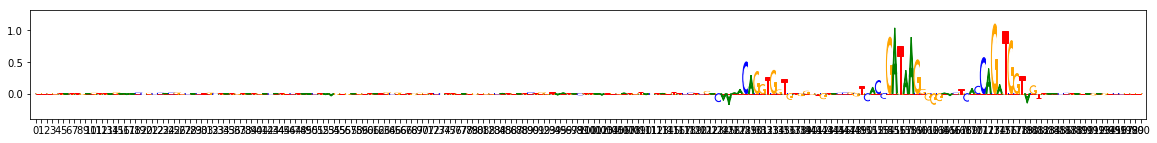

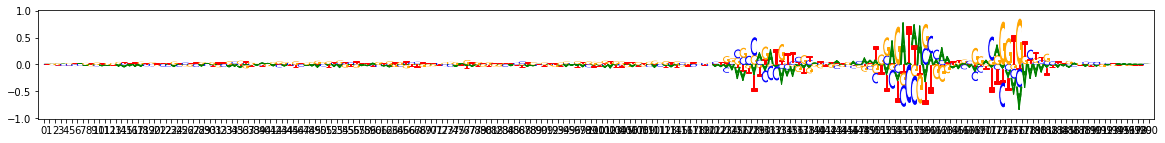

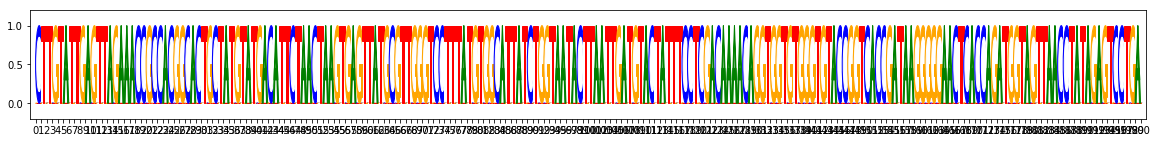

In [10]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there is just one task, there are only 2 possible metaclusters: +1 for the task and -1 for the task. The -1 metacluster does not turn up any motifs after noise filtering, but the +1 metacluster produces two motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

On task task0
Done 0


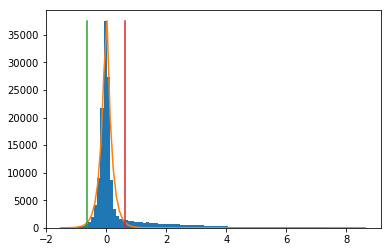

Computed threshold 0.6416451864009939
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Got 7573 coords
1851 coords remaining after thresholding
On task task1
Done 0


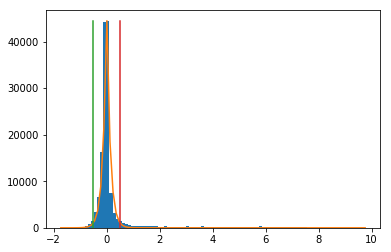

Computed threshold 0.5160285779594265
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Got 7575 coords
1530 coords remaining after thresholding
On task task2
Done 0


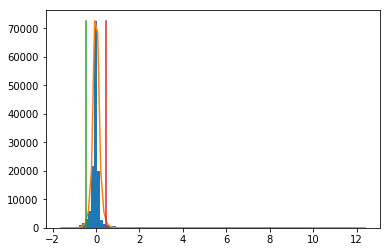

Computed threshold 0.445660070894207
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Done 0
Got 7575 coords
1653 coords remaining after thresholding
After resolving overlaps, got 2660 seqlets
3 activity patterns with support >= 200 out of 27 possible patterns
Metacluster sizes:  [789, 733, 724]
Idx to activities:  {0: '1,0,1', 1: '1,1,1', 2: '1,1,0'}
On metacluster 2
Metacluster size 724
Relevant tasks:  ('task0', 'task1')
Relevant signs:  (1, 1)
(Round 1) num seqlets: 724
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.75 s
Starting affinity matrix computations
Normalization computed in 0.01 s
Cosine similarity mat computed in 0.01 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.01 s
Finished affinity matrix computations in 0.03 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.03 s
(Round 1) Computing affinity matrix on nearest neighbo

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.4s finished


Louvain completed 200 runs in 1.9210088253 seconds
Wrote graph to binary file in 0.202742099762 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.668609
After 2 runs, maximum modularity is Q = 0.677612
After 5 runs, maximum modularity is Q = 0.678774
After 12 runs, maximum modularity is Q = 0.682489
After 16 runs, maximum modularity is Q = 0.684703
After 19 runs, maximum modularity is Q = 0.687067
After 38 runs, maximum modularity is Q = 0.687661
After 77 runs, maximum modularity is Q = 0.69359
Louvain completed 127 runs in 2.57611393929 seconds
Preproc + Louvain took 4.81229901314 s
Got 7 clusters after round 1
Counts:
{0: 136, 1: 132, 2: 107, 3: 95, 4: 56, 5: 48, 6: 43}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 136 seqlets
Trimmed 5 out of 136
Skipped 17 seqlets
Aggregating for cluster 1 with 132 seqlets
Trimmed 10 out of 132
Skipped 8 seqlets
Aggregating for cluster 2 with 107 seqlets
Trimmed 11 out of 107
Sk

[Parallel(n_jobs=20)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.4s finished


Louvain completed 200 runs in 1.8251979351 seconds
Wrote graph to binary file in 0.111702919006 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.70528
After 7 runs, maximum modularity is Q = 0.7215
Louvain completed 57 runs in 0.974271059036 seconds
Preproc + Louvain took 3.00408387184 s
Got 9 clusters after round 2
Counts:
{0: 79, 1: 76, 2: 55, 3: 54, 4: 37, 5: 33, 6: 31, 7: 31, 8: 29}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 79 seqlets
Trimmed 9 out of 79
Aggregating for cluster 1 with 76 seqlets
Trimmed 2 out of 76
Aggregating for cluster 2 with 55 seqlets
Trimmed 8 out of 55
Skipped 3 seqlets
Aggregating for cluster 3 with 54 seqlets
Trimmed 11 out of 54
Aggregating for cluster 4 with 37 seqlets
Trimmed 4 out of 37
Aggregating for cluster 5 with 33 seqlets
Trimmed 0 out of 33
Aggregating for cluster 6 with 31 seqlets
Trimmed 2 out of 31
Aggregating for cluster 7 with 31 seqlets
Trimmed 1 out of 31
Aggregat

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 2.23829913139 seconds
Wrote graph to binary file in 0.219642162323 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.662322
Louvain completed 51 runs in 1.16331791878 seconds
Preproc + Louvain took 3.73703885078 s
Got 5 clusters after round 1
Counts:
{0: 241, 1: 205, 2: 140, 3: 96, 4: 26}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 241 seqlets
Trimmed 10 out of 241
Skipped 24 seqlets
Dropping cluster 0 with 207 seqlets due to sign disagreement
Aggregating for cluster 1 with 205 seqlets
Trimmed 19 out of 205
Skipped 13 seqlets
Aggregating for cluster 2 with 140 seqlets
Trimmed 4 out of 140
Skipped 15 seqlets
Dropping cluster 2 with 121 seqlets due to sign disagreement
Aggregating for cluster 3 with 96 seqlets
Trimmed 12 out of 96
Skipped 11 seqlets
Aggregating for cluster 4 with 26 seqlets
Trimmed 0 out of 26
Skipped 8 seqlets
Dropping cluster 4 with 18 seqlets due to sign disagreement

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.2s finished


Louvain completed 200 runs in 1.58452105522 seconds
Wrote graph to binary file in 0.0448110103607 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.594014
After 3 runs, maximum modularity is Q = 0.611524
After 19 runs, maximum modularity is Q = 0.611703
After 57 runs, maximum modularity is Q = 0.612953
Louvain completed 107 runs in 1.68470001221 seconds
Preproc + Louvain took 3.37209200859 s
Got 5 clusters after round 2
Counts:
{0: 98, 1: 74, 2: 35, 3: 35, 4: 4}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 98 seqlets
Trimmed 0 out of 98
Aggregating for cluster 1 with 74 seqlets
Trimmed 1 out of 74
Aggregating for cluster 2 with 35 seqlets
Trimmed 0 out of 35
Aggregating for cluster 3 with 35 seqlets
Trimmed 0 out of 35
Aggregating for cluster 4 with 4 seqlets
Trimmed 0 out of 4
Got 5 clusters
Splitting into subclusters...
Inspecting for spurious merging
Wrote graph to binary file in 0.014111995697 seconds
Running L

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.5s finished


Louvain completed 200 runs in 2.21520209312 seconds
Wrote graph to binary file in 0.212233066559 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.742368
Louvain completed 51 runs in 1.21982383728 seconds
Preproc + Louvain took 3.77803206444 s
Got 7 clusters after round 1
Counts:
{0: 140, 1: 122, 2: 115, 3: 93, 4: 70, 5: 51, 6: 50}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 140 seqlets
Trimmed 10 out of 140
Skipped 19 seqlets
Aggregating for cluster 1 with 122 seqlets
Trimmed 9 out of 122
Skipped 9 seqlets
Aggregating for cluster 2 with 115 seqlets
Trimmed 1 out of 115
Skipped 31 seqlets
Dropping cluster 2 with 83 seqlets due to sign disagreement
Aggregating for cluster 3 with 93 seqlets
Trimmed 1 out of 93
Skipped 14 seqlets
Aggregating for cluster 4 with 70 seqlets
Trimmed 26 out of 70
Skipped 6 seqlets
Aggregating for cluster 5 with 51 seqlets
Trimmed 2 out of 51
Skipped 8 seqlets
Aggregating for cluster 6 wit

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 200 out of 200 | elapsed:    1.6s finished


Louvain completed 200 runs in 2.17181110382 seconds
Wrote graph to binary file in 0.106611013412 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.624696
After 2 runs, maximum modularity is Q = 0.62956
After 10 runs, maximum modularity is Q = 0.631117
After 11 runs, maximum modularity is Q = 0.631278
After 12 runs, maximum modularity is Q = 0.633393
Louvain completed 62 runs in 1.39448881149 seconds
Preproc + Louvain took 3.77215886116 s
Got 8 clusters after round 2
Counts:
{0: 78, 1: 75, 2: 67, 3: 45, 4: 43, 5: 40, 6: 27, 7: 12}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 78 seqlets
Trimmed 0 out of 78
Aggregating for cluster 1 with 75 seqlets
Trimmed 6 out of 75
Aggregating for cluster 2 with 67 seqlets
Trimmed 9 out of 67
Skipped 1 seqlets
Aggregating for cluster 3 with 45 seqlets
Trimmed 0 out of 45
Aggregating for cluster 4 with 43 seqlets
Trimmed 1 out of 43
Aggregating for cluster 5 with 40 seqlets
Trimmed 

In [13]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.theano_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

In [14]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

metacluster0
activity pattern: [1 0 1]
pattern_0
total seqlets: 331
Task 0 hypothetical scores:


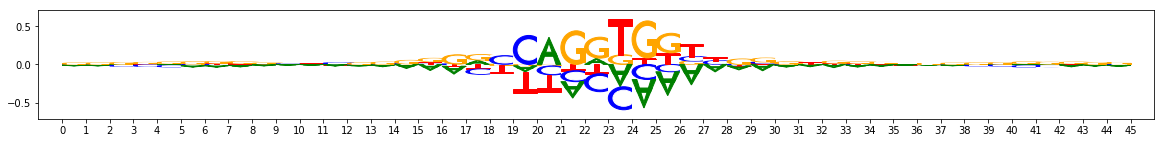

Task 0 actual importance scores:


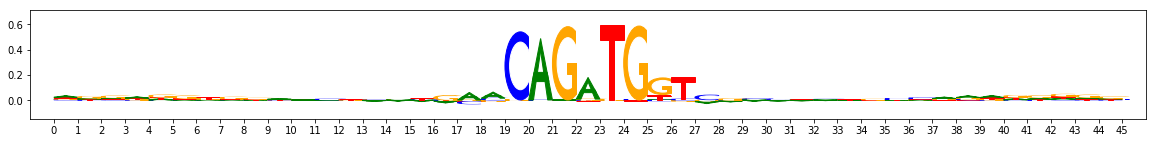

Task 1 hypothetical scores:


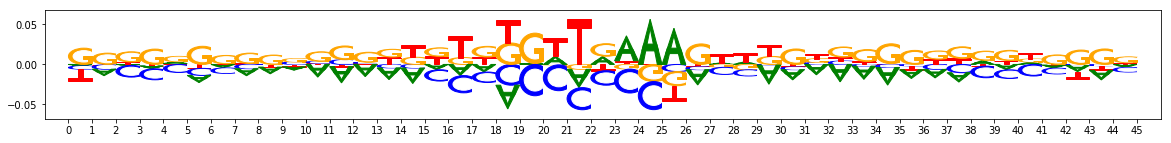

Task 1 actual importance scores:


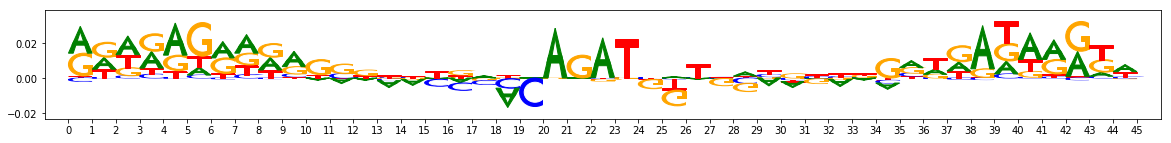

Task 2 hypothetical scores:


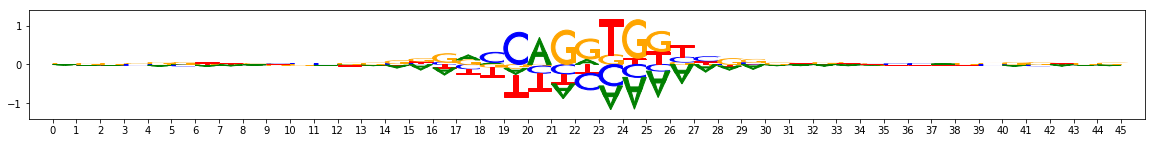

Task 2 actual importance scores:


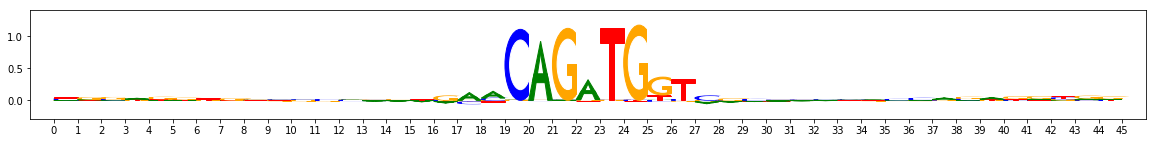

onehot, fwd and rev:


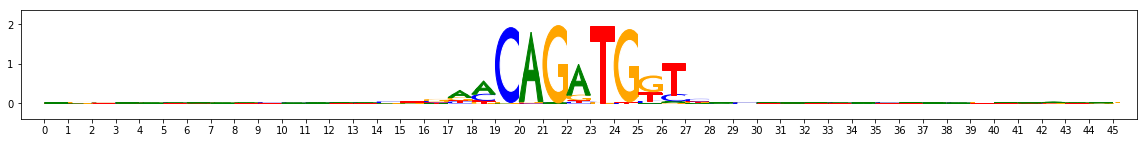

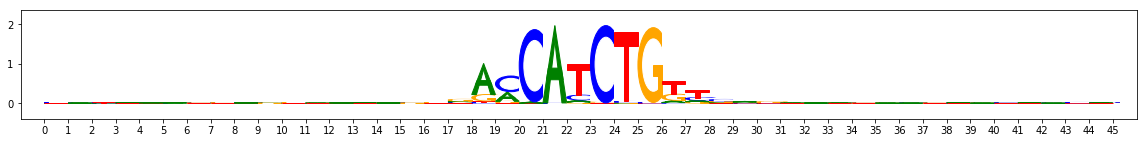

metacluster1
activity pattern: [1 1 1]
pattern_0
total seqlets: 169
Task 0 hypothetical scores:


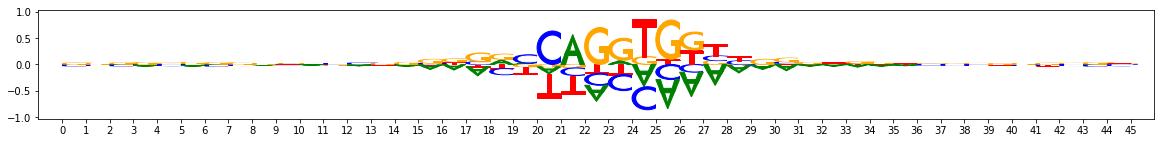

Task 0 actual importance scores:


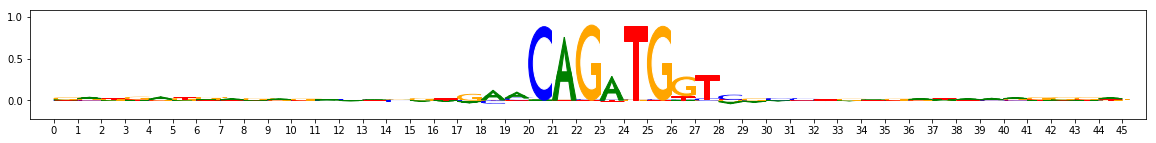

Task 1 hypothetical scores:


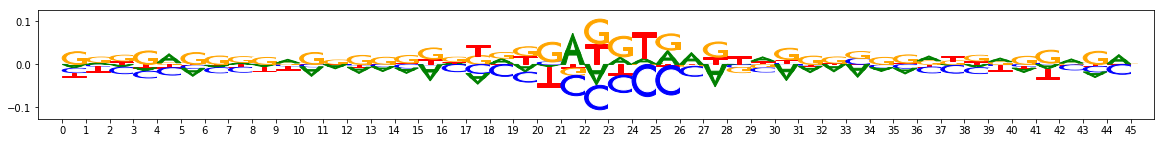

Task 1 actual importance scores:


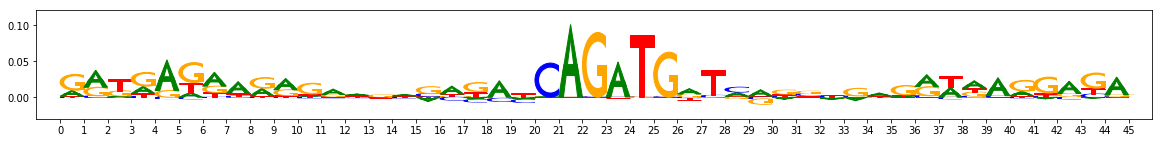

Task 2 hypothetical scores:


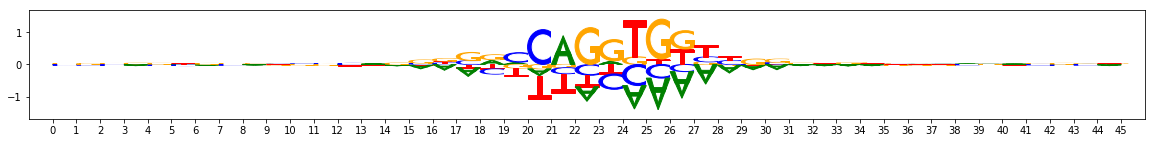

Task 2 actual importance scores:


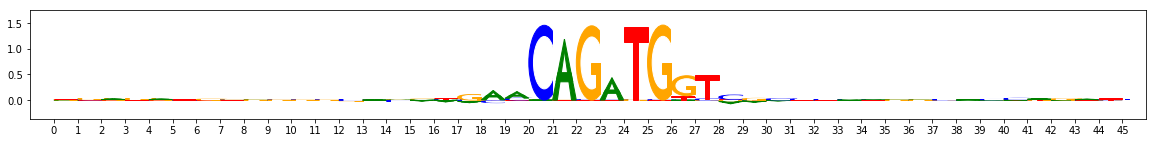

onehot, fwd and rev:


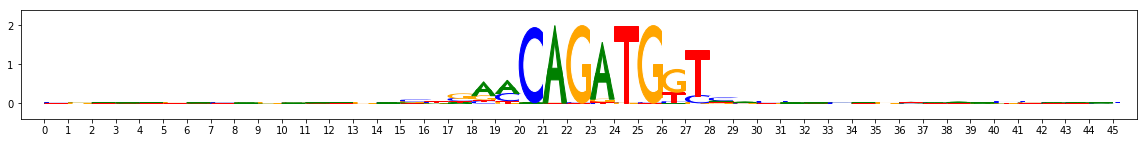

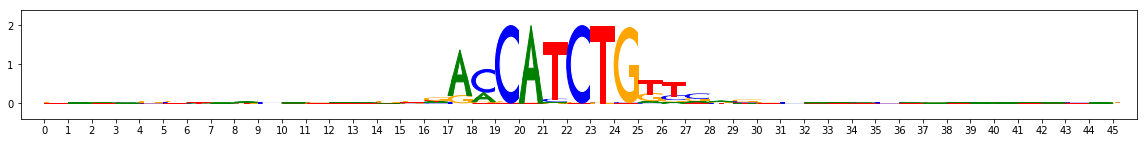

pattern_1
total seqlets: 73
Task 0 hypothetical scores:


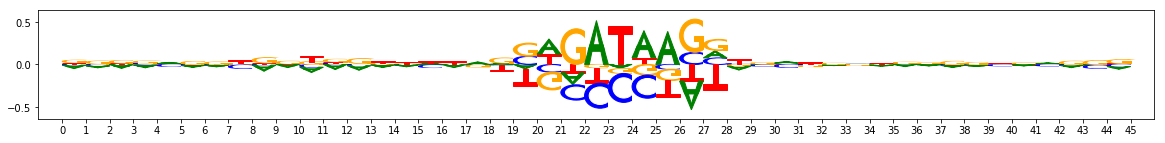

Task 0 actual importance scores:


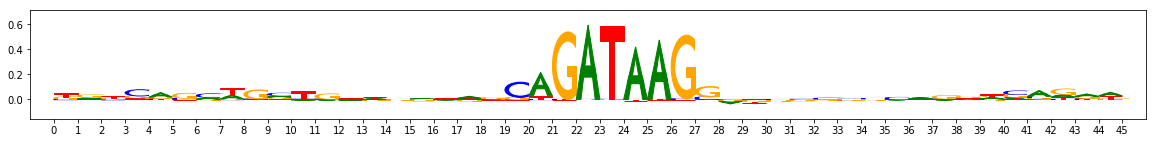

Task 1 hypothetical scores:


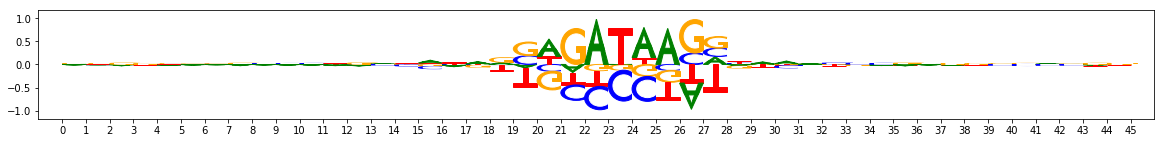

Task 1 actual importance scores:


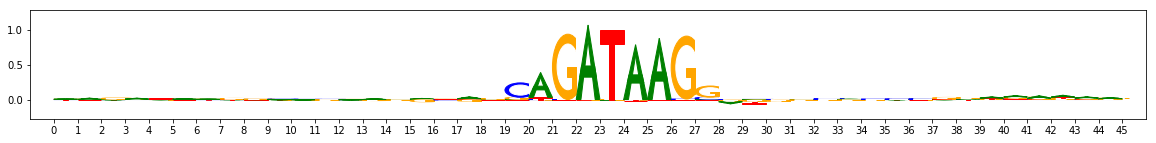

Task 2 hypothetical scores:


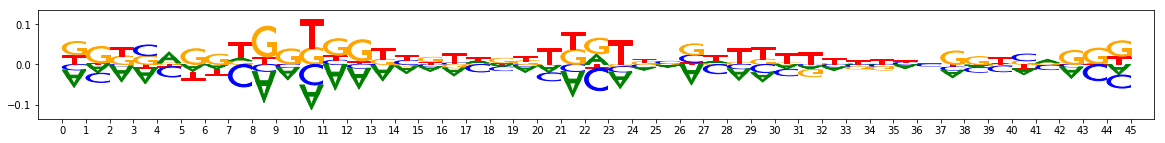

Task 2 actual importance scores:


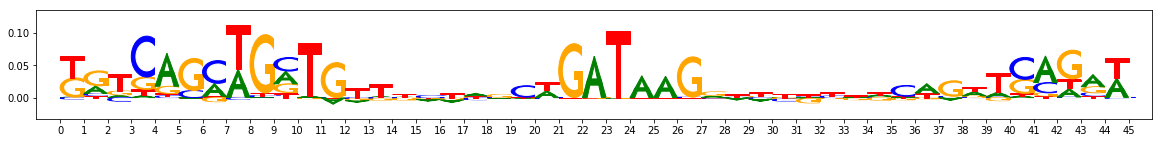

onehot, fwd and rev:


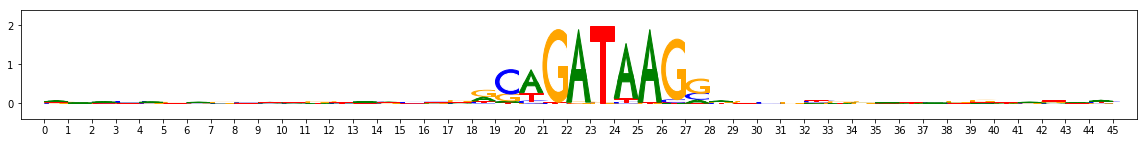

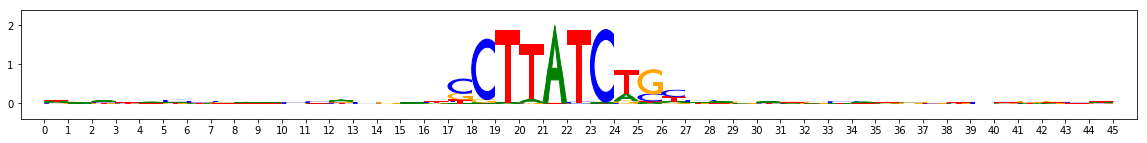

metacluster2
activity pattern: [1 1 0]
pattern_0
total seqlets: 323
Task 0 hypothetical scores:


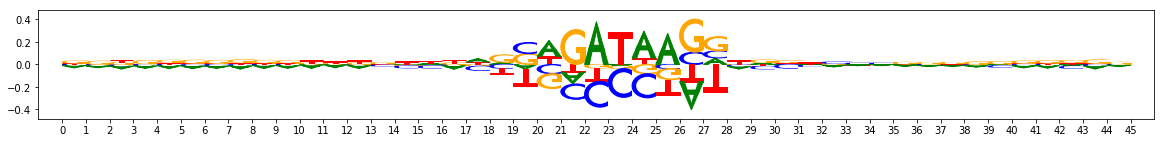

Task 0 actual importance scores:


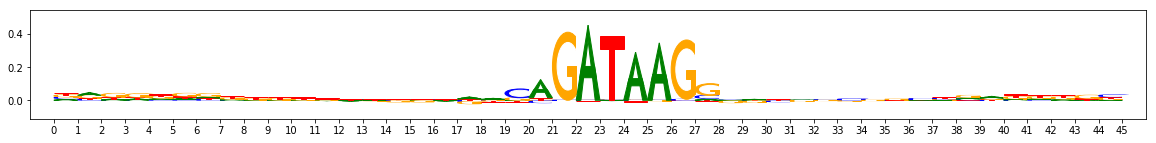

Task 1 hypothetical scores:


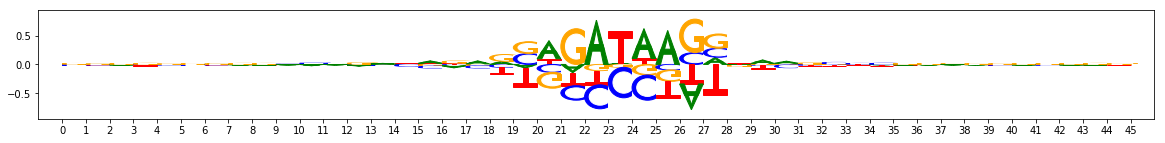

Task 1 actual importance scores:


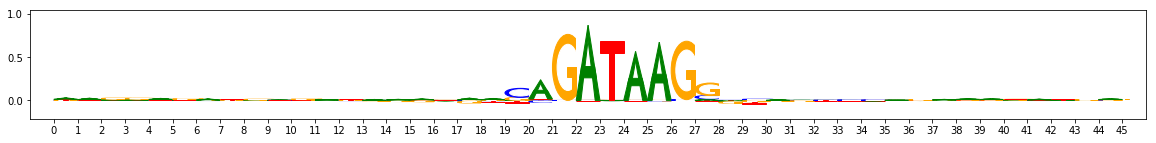

Task 2 hypothetical scores:


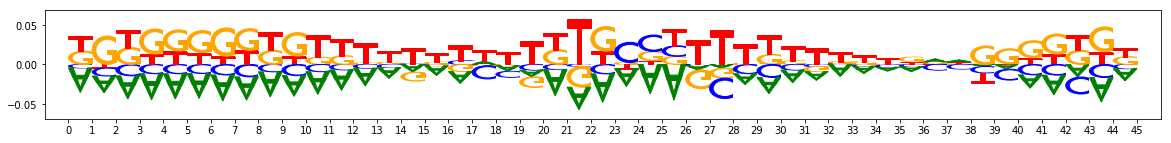

Task 2 actual importance scores:


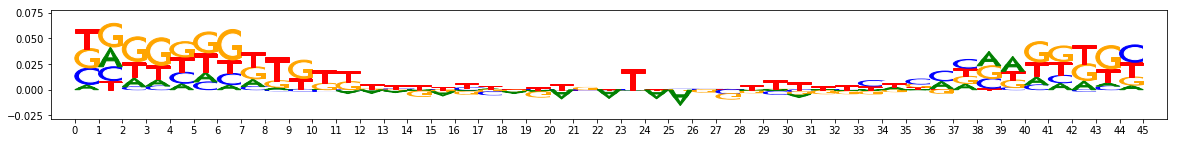

onehot, fwd and rev:


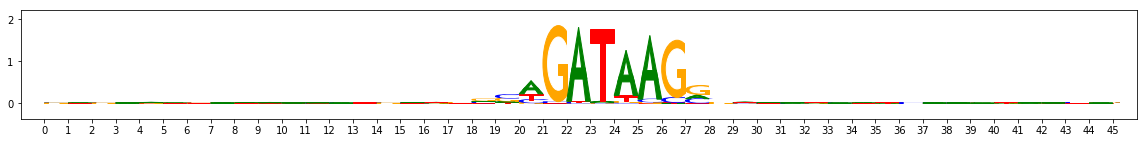

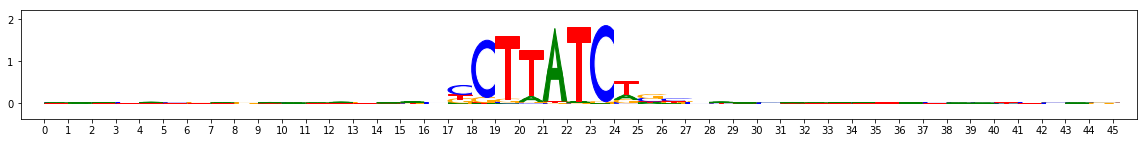

In [15]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5")

metacluster_names = list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = (list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:]))
    for pattern_name in all_pattern_names:
        print(pattern_name)
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()